# Introduction, Motivation and Background
The rate at which music is updated to different services -from all sorts of streaming platforms to direct download sites- is rapdly increasing. As a consequence, the task to properly identify the genre of a song is a hot problem with plenty of applications. To mention one, it is crucial for song-recommendation algorithms.

The machine learning answers to this problem have been numerous throughout the last years, with convolutional neural networks getting the upper hand as of late (as it is happening with so many other problem settings). The challenges here are not small: musical genres are loosely defined, so much so that people often argue over the genre of a song. Moreover, extracting features from audio data that can then feed a model is not an easy task. This is different from image classification problems, for instance, where labels usually leave less room for discussion and the information from color channels etc. of a pixel can be obtained straight away.

This work aims to classify songs depending on their genre through machine learning algorithms, with a special focus on NN methods. We work on the GTZAN dataset, carefully detailed below. Moreover, we want to be able to give our model songs out of the dataset and see what genre our models think it belongs too.

---

# Importing libraries

In [1]:
# linear algebra, plotting, ml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random
import seaborn as sns

# operative system commands
import sys
import os

# serailizing
import pickle

# audio analysis
import librosa
import librosa.display
import IPython #.display import Audio 

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# DL and CNN
import tensorflow as tf
from tensorflow import keras

# debugging
from icecream import ic

---

# GTZAN Dataset
## Summary
The GTZAN dataset was created by G. Tzanetakis in 2002 and is by far the most commonly used for all sorts of music genre classification problems (and many other similar settings). It comprehends:
 - 1000 audio files of 30 second each, all of them 22050Hz Mono 16-bit audio files in .wav format. The audios are equally distributed (manually labeled) into 10 genres (100 audios per group).
 - For each audio we have the mean and variance of as much as 57 numeric audio features (explained in depth below).
 - As a data augmentation technique, each audio is chopped 10 times (in 3 secomd splits) and its corresponding features are also present in the dataset.
 
To build our model, we are going to work on the 3 second chops as it provides more data for training and is less sensible to abrupt changes along an audio. 

## Dataset quality and bias disclaimer
Many works fail to warn that the GTZAN has plenty of flaws. It is not so commonly used because its high quality, but because of the the absence of other viable datasets. The main reason for this scarce of data is that music companies are reticent to give their product for free for research. Even for GTZAN, the ways in which the dataset was gathered are legally questionable...
Thus, we have to take into account that the data we work with is indeed not good. To mention some of its defects:
 - 1000 tracks are quite few for machine learning problems
 - Many music genres are underepresented (or not represented at all)
 - Some audios are arguably misslabeled
 - Some audios are distorted
 - Some audios are duplicated
 - Some audios are different extracts from the same song (or different versions)
 - Some artists are overrepresented in their genres (35% of the reggae labeled audios belong to Bob Marley!)
 
The direct consecuence of this, is that no matter how good we train our model, it may not behave properly with the (many) songs that are poorly represented in our flawed dataset.
 
__Reference__: *Sturm, B. L. (2012). An analysis of the GTZAN music genre dataset. MIRUM 2012 - Proceedings of the 2nd International ACM Workshop on Music Information Retrieval with User-Centered and Multimodal Strategies, Co-Located with ACM Multimedia 2012, 7–12. https://doi.org/10.1145/2390848.2390851*

In [2]:
df = pd.read_csv('data/features_3_sec.csv')
df.head(11)

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0   blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1   blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2   blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3   blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4   blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
5   blues.00000.5.wav   66149          0.376670         0.089702  0.132618   
6   blues.00000.6.wav   66149          0.379909         0.088827  0.130335   
7   blues.00000.7.wav   66149          0.331880         0.092119  0.140600   
8   blues.00000.8.wav   66149          0.347877         0.094209  0.133130   
9   blues.00000.9.wav   66149          0.358061         0.082957  0.115312   
10  blues.00001.0.wav   66149          0.402401         0.090340  0.093024   

     rms_var  spectral_centroid_mean  spectral_centroid_var  \
0   0.003521             1773.065032          167541.630869   
1   0.001450             1816.693777           90525.690866   
2   0.004620             1788.539719          111407.437613   
3   0.002448             1655.289045          111952.284517   
4   0.001701             1630.656199           79667.267654   
5   0.003583             1994.915219          211700.619569   
6   0.003166             1962.150096          177443.070045   
7   0.002546             1701.890924           35678.130616   
8   0.002538             1746.473502          138073.931244   
9   0.001846             1763.948942           61493.423121   
10  0.003876             1279.182242          406513.816744   

    spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0               1972.744388           117335.771563  ...   39.687145   
1               2010.051501            65671.875673  ...   64.748276   
2               2084.565132            75124.921716  ...   67.336563   
3               1960.039988            82913.639269  ...   47.739452   
4               1948.503884            60204.020268  ...   30.336359   
5               2152.767854            74263.873102  ...   31.448069   
6               2146.503479            98020.541422  ...   33.954071   
7               1979.387612            36670.725886  ...   38.456211   
8               1887.619723           117069.920049  ...   44.311455   
9               1874.195710            51944.921435  ...   43.967834   
10              1921.306192           196573.441648  ...   39.640743   

    mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0     -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1     -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2     -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3     -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4      0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   
5     -3.448373   34.284130    -0.416165   40.791092    -3.649625   32.457901   
6     -2.068194   25.623655     1.428141   47.957699    -3.267124   39.382240   
7     -3.637886   24.530296    -0.105148   26.716150    -2.016985   23.150423   
8     -4.370029   29.873167     2.114592   33.843155    -2.264663   80.812393   
9     -3.448304   48.671944     0.099792   41.839546    -7.677177   96.253654   
10     1.263416   22.989195     0.136411   19.644432    -0.883823   20.996868   

    mfcc20_mean  mfcc20_var  label  
0     -0.243027   43.771767  blues  
1      5.784063   59.943081  blues  
2      2.517375   33.105122  blues  
3      3.630866   32.023678  blues  
4      0.536961   29.146694  blues  
5      3.025218   28.892687  blues  
6      3.276939   25.999132  blues  
7      0.210787   42.512966  blues  
8      3.758598   97.618835  blues  
9      0.791776   40.416420  blues  
10     0.375303   21.973501  blues  

[11 rows x 60 columns]

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9990.0       9990.000000      9990.000000  9990.000000  9.990000e+03   
mean   66149.0          0.379534         0.084876     0.130859  2.676388e-03   
std        0.0          0.090466         0.009637     0.068545  3.585628e-03   
min    66149.0          0.107108         0.015345     0.000953  4.379535e-08   
25%    66149.0          0.315698         0.079833     0.083782  6.145900e-04   
50%    66149.0          0.384741         0.085108     0.121253  1.491318e-03   
75%    66149.0          0.442443         0.091092     0.176328  3.130862e-03   
max    66149.0          0.749481         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9990.000000           9.990000e+03              9990.000000   
mean              2199.219431           4.166727e+05              2241.385959   
std                751.860611           4.349644e+05               543.854449   
min                472.741636           8.118813e+02               499.162910   
25%               1630.680158           1.231961e+05              1887.455790   
50%               2208.628236           2.650692e+05              2230.575595   
75%               2712.581884           5.624152e+05              2588.340505   
max               5432.534406           4.794119e+06              3708.147554   

       spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean   mfcc16_var  \
count            9.990000e+03   9990.000000  ...  9990.000000  9990.000000   
mean             1.182711e+05   4566.076592  ...     1.448240    49.988755   
std              1.013505e+05   1642.065335  ...     5.735149    34.442816   
min              1.183520e+03    658.336276  ...   -26.850016     1.325786   
25%              4.876553e+04   3378.311110  ...    -2.227478    29.584894   
50%              8.996072e+04   4631.377892  ...     1.461623    41.702393   
75%              1.585674e+05   5591.634521  ...     5.149752    59.274619   
max              1.235143e+06   9487.446477  ...    39.144405   683.932556   

       mfcc17_mean   mfcc17_var  mfcc18_mean   mfcc18_var  mfcc19_mean  \
count  9990.000000  9990.000000  9990.000000  9990.000000  9990.000000   
mean     -4.198706    51.962753     0.739943    52.488851    -2.497306   
std       5.677379    36.400669     5.181313    38.177120     5.111799   
min     -27.809795     1.624544   -20.733809     3.437439   -27.448456   
25%      -7.951722    29.863448    -2.516638    29.636197    -5.734123   
50%      -4.443021    42.393583     0.733772    41.831377    -2.702366   
75%      -0.726945    61.676964     3.888734    62.033906     0.514246   
max      34.048843   529.363342    36.970322   629.729797    31.365425   

        mfcc19_var  mfcc20_mean   mfcc20_var  
count  9990.000000  9990.000000  9990.000000  
mean     54.973829    -0.917584    57.322614  
std      41.585677     5.253243    46.444212  
min       3.065302   -35.640659     0.282131  
25%      30.496412    -4.004475    30.011365  
50%      43.435253    -1.030939    44.332155  
75%      65.328602     2.216603    68.210421  
max    1143.230591    34.212101   910.473206  

[8 rows x 58 columns]

## Understanding the Audio Features
We have now 57 different audio features to create our model, many of them derived from each other. But what do all of these represent? Here you find a brief explaination to understand what are we working with.

First of all, audio features are of 3 types depending on the information of the audio signal that they provide:
- __Time domain__: provide information of the audio signal over time.
- __Frequency domain__: provide information relating to the number of cycles that an audio signal makes over one second, often measured in Hz.
- __Time-Frequency domain__: features that provide information on both domains. Often derived using "Fast Fourier Transform" (FFT).

<img src="media/audio 3 dimension.png" width=400 height=400 />

With that introduced, let's see what our features tell us about the audios:
- __Time Domain__:
    - __Length__: duration of the audio.
    - __RMS__: root mean square energy. Simplyfying, it indicates loudness: the higher the energy, the louder the sound.
    - __Zero crossing rate__: number of times a waveform changes sign (crosses the x-axis).
    - __Tempo__: speed of the track, measured in beats per minute.
- __Frequency and time/frequency domain__:
    - __Chroma STFT__: vector corresponding to the total energy of the signal for each of the 12 semitone pitches (with disregard of the octave).
    - __Spectral centroid__: represents the frequency band where most of the energy is concentrated. It maps into a feature called "brightness of sound," which can be energetic, open, dull...
    - __Spectral bandwidth__: variance from the spectral centroid, i.e: weighted mean of the distances of frequency bands from the Spectral Centroid.
    - __Spectral rolloff__: Frequency below which 85% of the total spectral energy lies.
    - __MFCCs__: the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound. It is made up with a number of coefficients or MFCCs. These are widely used in audio analysis and machine learning because of their ease of extraction.

Harmonic sounds are sounds we perceive to have a specific pitch, whereas percussive sounds are often perceived as the result of two colliding objects. These can be separated and are represented in the last two features:
- __Harmony__:  harmonic split of the audio.
- __Perceptr__: percussive part of the audio.

More information on: *Saranga, K. Mahanta, arvindpdmn. Devopedia (2021). "Audio Feature Extraction." Version 8, May 23. Accessed 2021-05-23. https://devopedia.org/audio-feature-extraction*

## Preliminary data exploration
Let's graphically explore a couple of the audio files with the aim to understand our features a bit better and to see what is noticable to the eye. 

We are first going to pick through LibROSA one reggae and one classical clip.

In [4]:
# librosa.load outputs:
    # a decoding of the audio as a time series and 
    # the sampling rate (by default 45600Hz)
data, sr = librosa.load('data/genres_original/reggae/reggae.00008.wav')
data2, sr2 = librosa.load('data/genres_original/classical/classical.00008.wav')

# IPython allows to play the audio
IPython.display.Audio(data, rate=sr)

In [5]:
IPython.display.Audio(data2, rate=sr2)

Plotting the waveshow: graph of $time \times amplitude$.

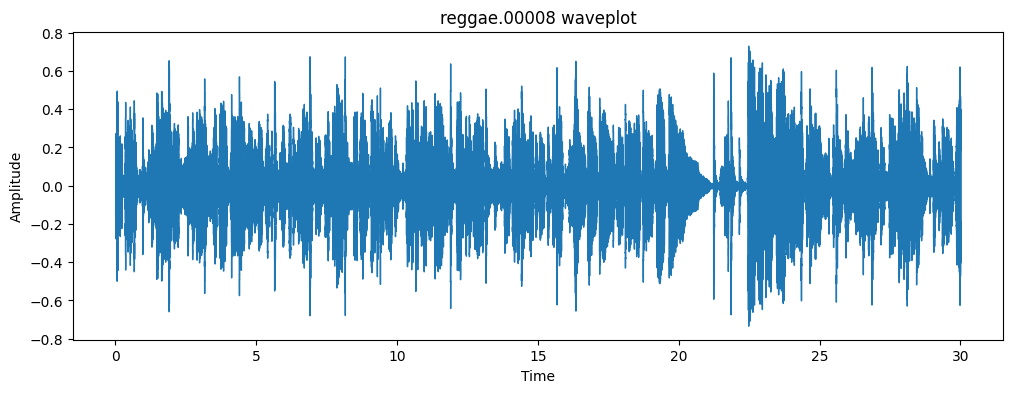

In [6]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr)
plt.title("reggae.00008 waveplot")
plt.ylabel("Amplitude")
plt.show()

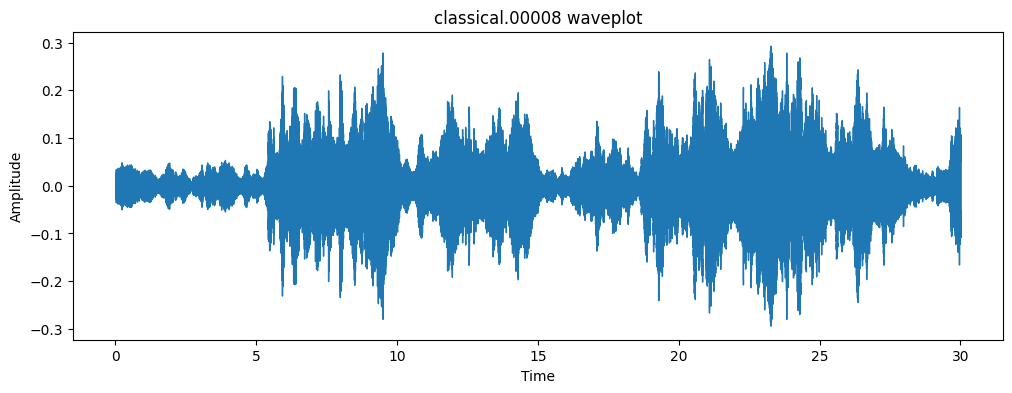

In [7]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data2, sr=sr2)
plt.title("classical.00008 waveplot")
plt.ylabel("Amplitude")
plt.show()

Let's plot now the spectral rolloff (frequency below which 85% of the energy lies).

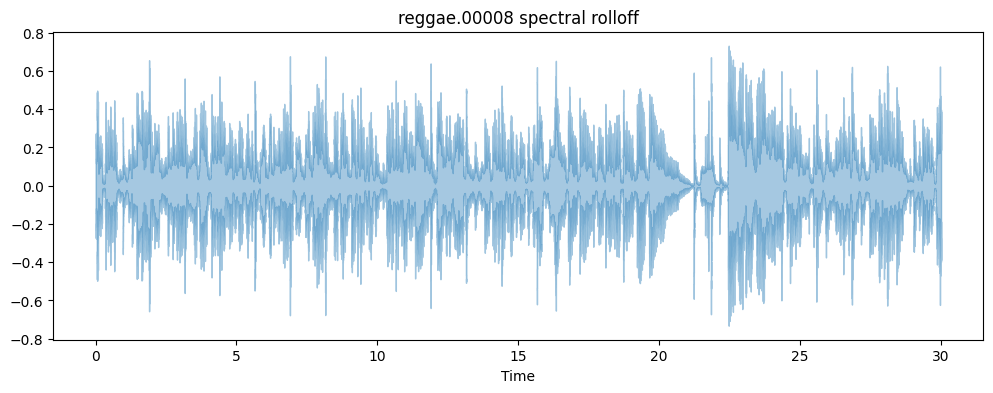

In [8]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(y=data+0.01, sr=sr)[0]
plt.figure(figsize=(12,4))
plt.title("reggae.00008 spectral rolloff")
librosa.display.waveshow(data, sr=sr, alpha=0.4)

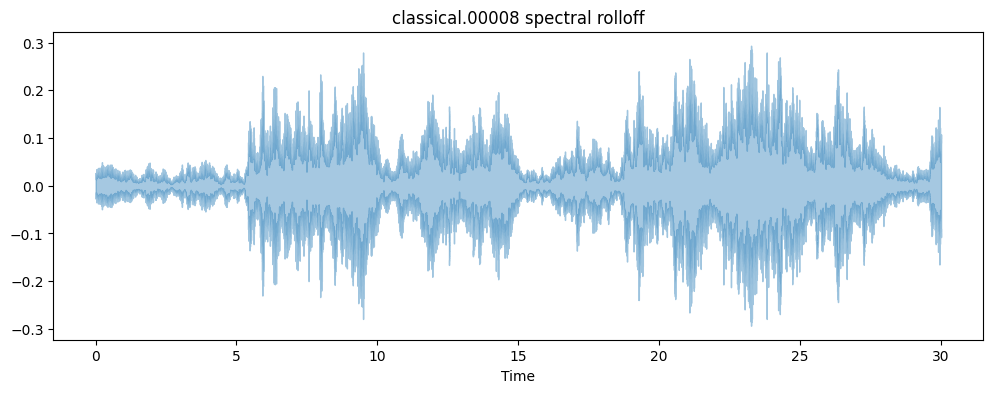

In [9]:
spectral_rolloff2 = librosa.feature.spectral_rolloff(y=data2+0.01, sr=sr2)[0]
plt.figure(figsize=(12,4))
plt.title("classical.00008 spectral rolloff")
librosa.display.waveshow(data2, sr=sr2, alpha=0.4)

Plotting the harmonics and percussive parts of the audio:

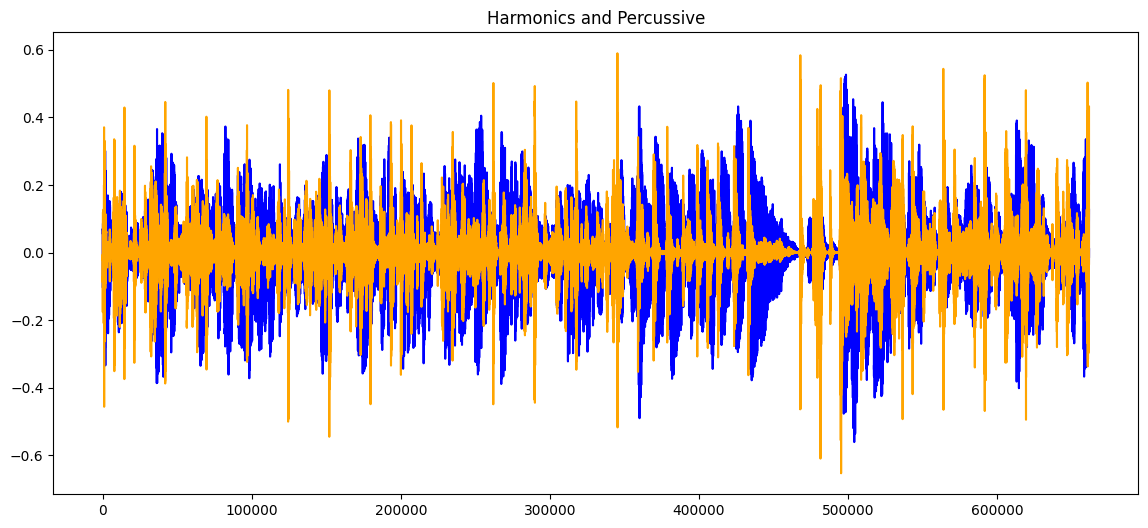

In [10]:
harm,perc = librosa.effects.hpss(data)
plt.figure(figsize = (14, 6))
plt.plot(harm, color= 'blue' )
plt.plot(perc, color= 'orange')
plt.title('Harmonics and Percussive')
plt.show()

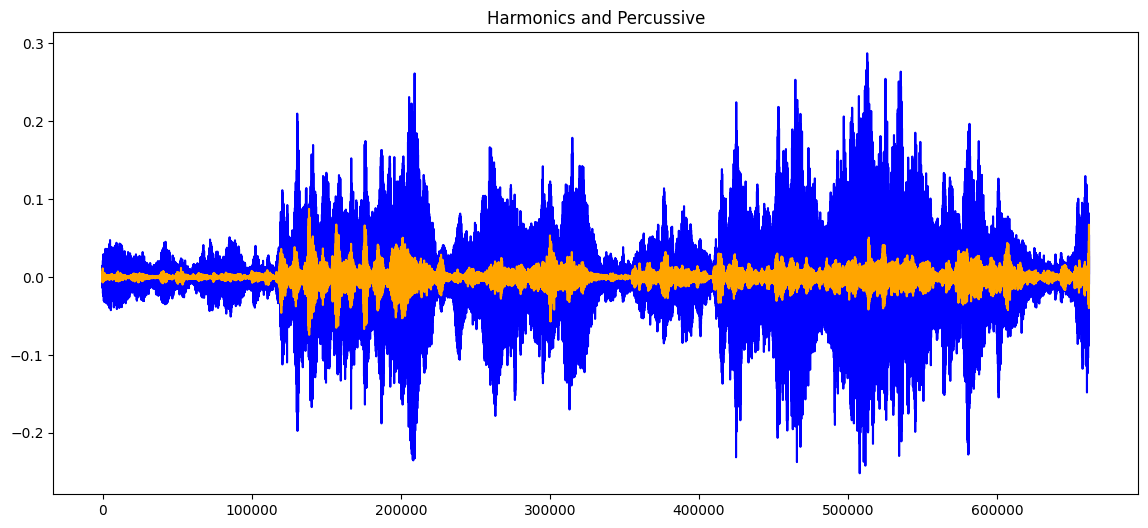

In [11]:
a2,b2 = librosa.effects.hpss(data2)
plt.figure(figsize = (14, 6))
plt.plot(a2, color='blue')
plt.plot(b2, color= 'orange')
plt.title('Harmonics and Percussive')
plt.show()

Plotting the Spectogram(s): the represent $time \times frequency$ (measured in Hz), after scaling the amplitude into decibels.

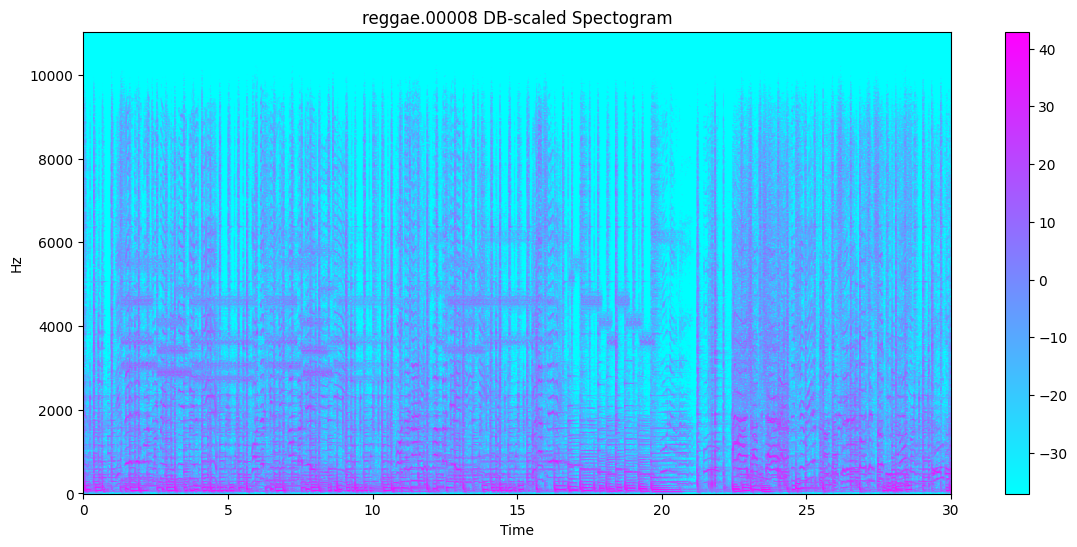

In [12]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))

plt.figure(figsize=(14,6))
plt.title("reggae.00008 DB-scaled Spectogram")
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz', cmap = 'cool')
plt.colorbar()

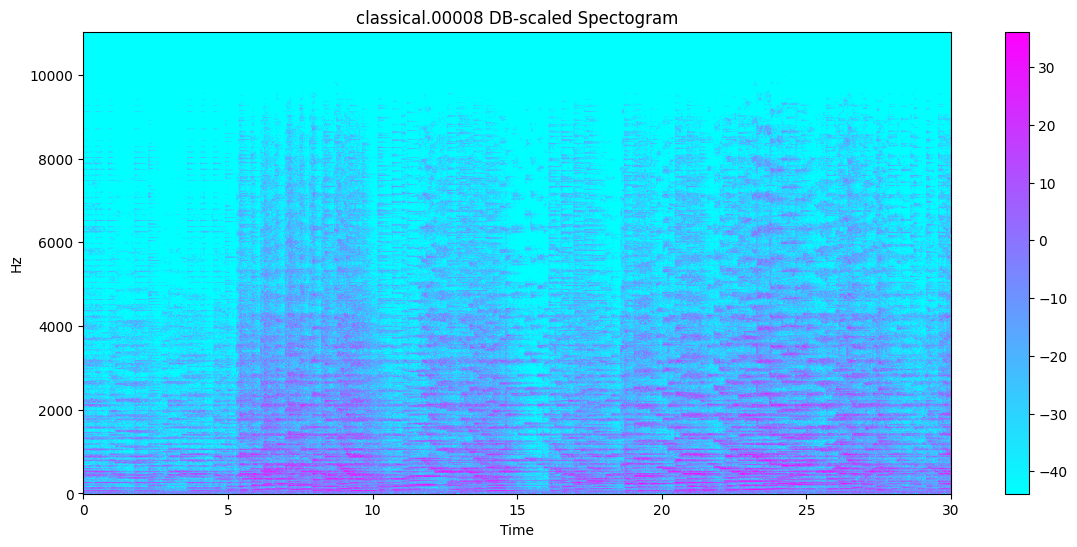

In [13]:
stft2 = librosa.stft(data2)
stft_db2 = librosa.amplitude_to_db(abs(stft2))

plt.figure(figsize=(14,6))
plt.title("classical.00008 DB-scaled Spectogram")
librosa.display.specshow(stft_db2, sr=sr2, x_axis='time', y_axis='hz', cmap = 'cool')
plt.colorbar()

We plot now the chroma feature, which is able to analyze features whose pitches can be categorized and whose tuning approximates to the equal tempered scale. 

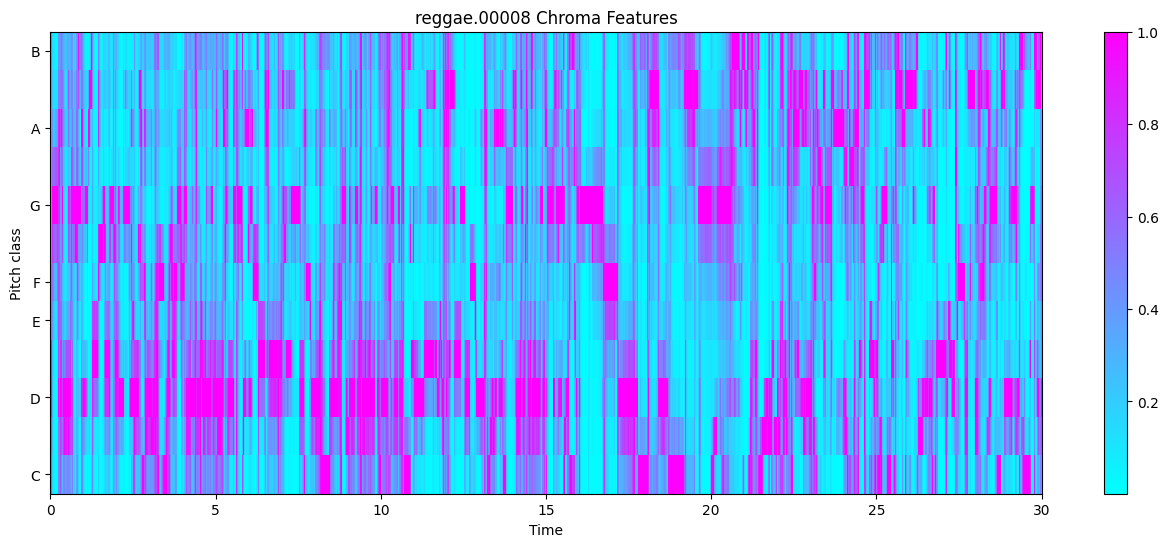

In [14]:
chroma = librosa.feature.chroma_stft(y=data, sr=sr)
plt.figure(figsize=(16,6))
librosa.display.specshow(chroma, sr=sr, x_axis = 'time', y_axis='chroma', cmap='cool')
plt.colorbar()
plt.title("reggae.00008 Chroma Features")
plt.show()

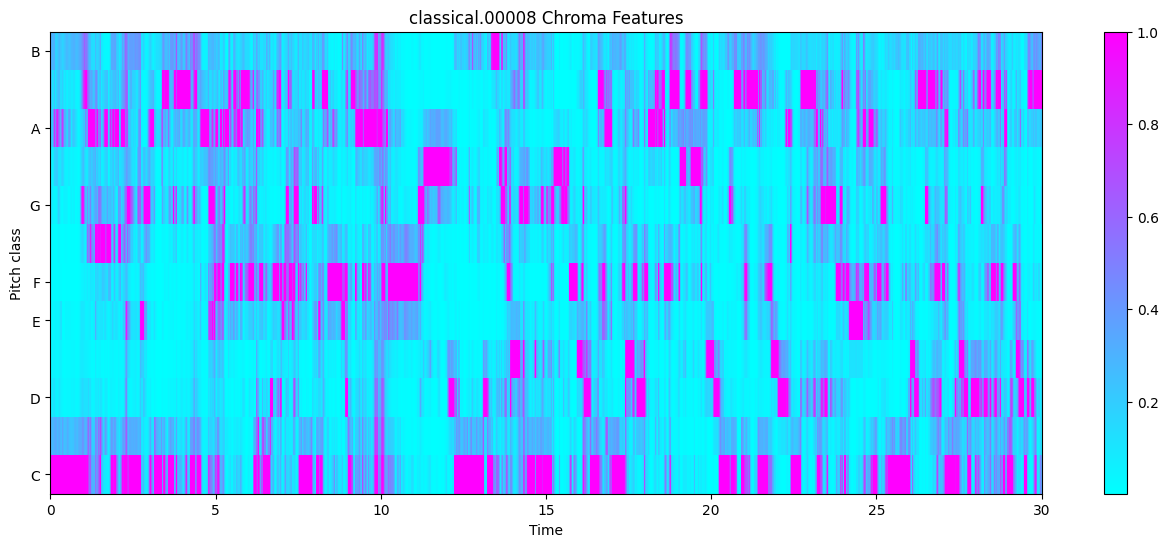

In [15]:
chroma2 = librosa.feature.chroma_stft(y=data2, sr=sr2)
plt.figure(figsize=(16,6))
librosa.display.specshow(chroma2, sr=sr2, x_axis = 'time', y_axis='chroma', cmap='cool')
plt.colorbar()
plt.title("classical.00008 Chroma Features")
plt.show()

Let's make a plot for the zero-crossing rate: the number of times that the amplitude of a signal crosses zero (changes sign) over a lapse of time.

6


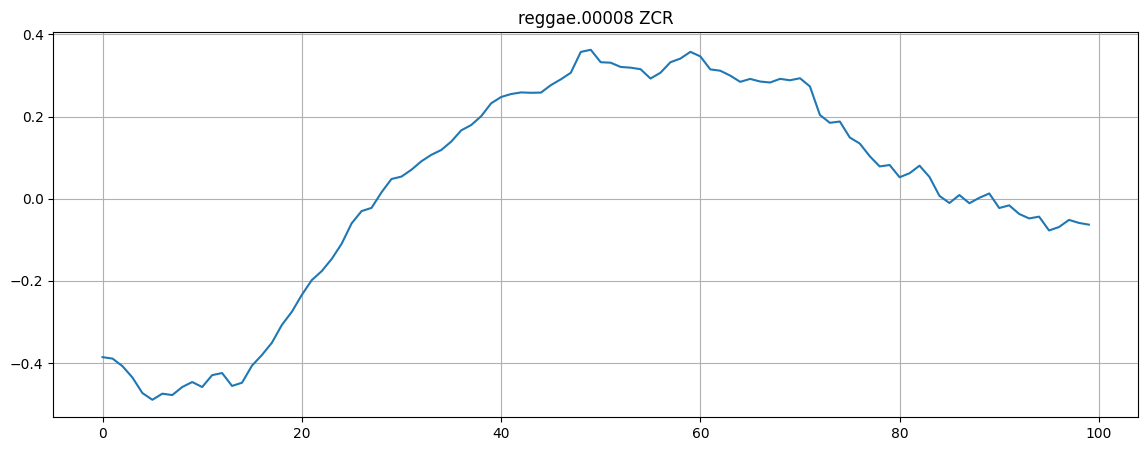

In [16]:
start = 1000
end = 1100
plt.figure(figsize=(14,5))
plt.plot(data[start:end])
plt.title("reggae.00008 ZCR")
plt.grid()
zero_cross_rate = librosa.zero_crossings(data[start:end], pad=False)
print(sum(zero_cross_rate))

3


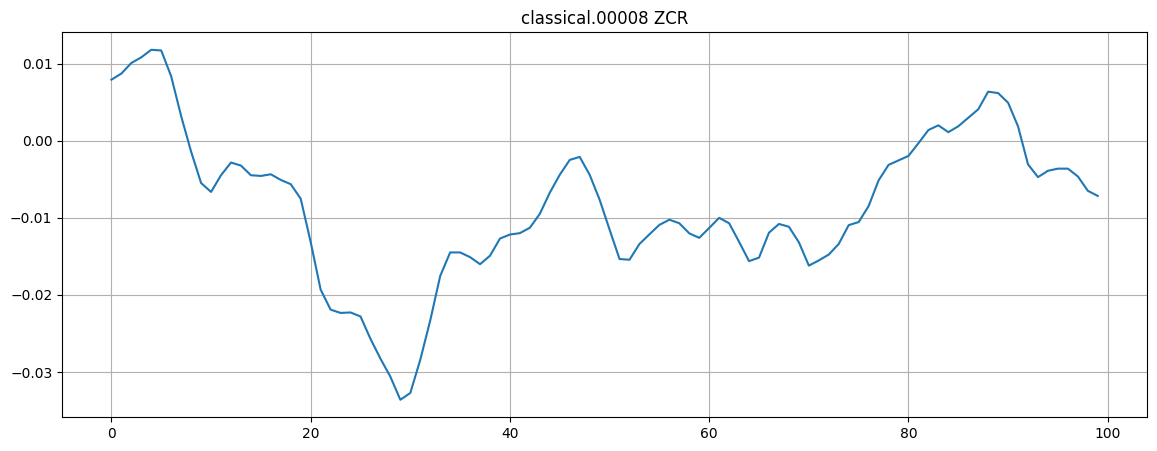

In [17]:
start = 1000
end = 1100
plt.figure(figsize=(14,5))
plt.plot(data2[start:end])
plt.title("classical.00008 ZCR")
plt.grid()
zero_cross_rate = librosa.zero_crossings(data2[start:end], pad=False)
print(sum(zero_cross_rate))

The __conclussion__ that I can draw is that it seems quite impossible to distinguish music genres on base of any of the prior plots. Let's explore then what our models can find.

Most of the credit of the plots in this exploratory section is due to: *Velardo, Valerio (2020-2021). The sound of AI, Youtube. https://www.youtube.com/c/ValerioVelardoTheSoundofAI/videos*

---

# Data preprocessing
Let's work our data around to make it suitable for a NN. We will first drop the attributes that are not necessary, then deal with the attributes that are not numerical and finally normalize all values to make them comparable.

In [18]:
# We drop Filename as it is not numeric and not needed
df = df.drop(labels='filename', axis=1)

## Label encoding
We start by encoding for our 10 classes (genres). Instead of one-hot encoding, we assign a number (from 0 to 9) to each genre. These affect different aspects of the algorithms that we will use for predictions like the choice of the loss function (explained in each algorithm).

In [19]:
class_list = df.iloc [:,-1]
converter = LabelEncoder()
y = converter.fit_transform(class_list)
print(y)

[0 0 0 ... 9 9 9]


## Normalizing features
For the NN, we must standarize our features so they look alike and we can indeed compare them. In neural networks, large absolute values on the feature vectors are difficult to adjust through the learnt parameters. That is why we would prefer normalized values in between 0 and 1.In this case, we use Z-score normalization: it subtracts the mean to our feature and then we divide it by the variance: 


<center>$ ZScore  = \frac{x-\mu}{var} $</center>

Other normalization techniques like logarithmic scaling could be valid as well.

In [20]:
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:, :-1], dtype = float))
Xdf = pd.DataFrame(X) # just to have it as DataFrame as well

ic(df.head())
ic(Xdf.head())

ic| df.head():    length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
               0   66149          0.335406         0.091048  0.130405  0.003521   
               1   66149          0.343065         0.086147  0.112699  0.001450   
               2   66149          0.346815         0.092243  0.132003  0.004620   
               3   66149          0.363639         0.086856  0.132565  0.002448   
               4   66149          0.335579         0.088129  0.143289  0.001701   
               
                  spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
               0             1773.065032          167541.630869              1972.744388   
               1             1816.693777           90525.690866              2010.051501   
               2             1788.539719          111407.437613              2084.565132   
               3             1655.289045          111952.284517              1960.039988   
               4          

0         1         2         3         4         5         6         7   \
0  0.0 -0.487808  0.640520 -0.006624  0.235568 -0.566828 -0.572791 -0.493983   
1  0.0 -0.403142  0.131835 -0.264944 -0.342134 -0.508798 -0.749862 -0.425382   
2  0.0 -0.361694  0.764491  0.016695  0.542195 -0.546245 -0.701852 -0.288365   
3  0.0 -0.175714  0.205477  0.024885 -0.063820 -0.723482 -0.700599 -0.517344   
4  0.0 -0.485895  0.337521  0.181345 -0.272072 -0.756246 -0.774827 -0.538557   

         8         9   ...        48        49        50        51        52  \
0 -0.009229 -0.518590  ... -0.750122 -0.299108  0.168647 -0.425137 -0.003423   
1 -0.519010 -0.424118  ...  0.457983  0.428544 -0.327031 -0.310040 -0.112125   
2 -0.425734 -0.346190  ...  0.585548  0.503695  0.428053 -0.648762  0.316311   
3 -0.348881 -0.607665  ... -0.489524 -0.065309  0.062981 -0.649076  0.092384   
4 -0.572962 -0.667537  ...  0.112417 -0.570609  0.856651 -0.167089  0.183265   

         53        54        55        56        57  
0 -0.376938 -0.499464 -0.513562  0.128414 -0.291781  
1 -0.032083 -0.066593  1.011384  1.275780  0.056425  
2 -0.177372  0.109337 -0.046244  0.653907 -0.521458  
3 -0.464121 -0.211882 -0.099501  0.865880 -0.544744  
4 -0.029476 -0.175130 -0.678995  0.276899 -0.606692  

[5 rows x 58 columns]

## Train-Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

---

# Deep Learning approach: Neural Network
We are going to approach the classification problem first by implementing a convolutional neural network with Keras **over the numeric features** that we have previously preprocessed.

It is worth mentioning that attempts have been made on using CNN **on the spectogram images** that we can see on the graphs above, thus dealing with the problem as an image classification one. Although it seems promising, the results so far have not been compelling enough to surpass the ones on numeric features CNN.

<img src="media/spectograms.png" width=1000 height=1000 />

See an example of CNN as image classification on spectogram here: *Roberts, Leland. Towards Data Science (2020). "Musical Genre Classification with Convolutional Neural Networks." Accessed 2021-07-28. https://towardsdatascience.com/musical-genre-classification-with-convolutional-neural-networks-ff04f9601a74* They got 68% test accuracy, way below what I get on numeric values.

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.layers
import keras.utils
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

As we are diving into a multiclass-classification problem, we will use the probablisitic loss function __Categorical Crossentropy__ ($l(y,\hat{y})=-\Sigma _j y_j log\hat{y}_j$), which calculates the information loss in between predicted and real values. In our case we use the "Sparse" one by keras because our labels are not one-hot-encoded.  

With regards to the metrics used to judge the model's performance, we will simply use __accuracy__, which counts the number of occurences where our prediction matches the real label. Categorical crossentropy metric could have also been valid here.

We leave space when calling the function to define the epochs and optimizer.

In [23]:
# define function that trains our CNN
def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer = optimizer,
                  loss = 'sparse_categorical_crossentropy',
                  metrics = 'accuracy')
    return model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs,
                    batch_size = batch_size)

In [24]:
# define a function to plot the accuracy of our predictions
def plotValidate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

The credit for the specific CNN architecture implemented below is due to *Chowdhry, Arsh (2021). Music Genre Classification Using CNN, CLAIRVOYANT. https://blog.clairvoyantsoft.com/music-genre-classification-using-cnn-ef9461553726*. 

I have made multiple attempts to change some layers but none of them sheds as much accuracy as this one, so I decided to leave it as it is.

Briefly explained: we intersperse dense and droput layers progressively reducing the number of parameters. The __dense layers__ are nothing but a normal convolutional layer ($\hat{y} = w_i * x_i + b)$ followed by a non-linear activation function; __relu__ in this case ($ReLu(v)=max(0,v)$). The sigmoid function could have also applied in here, but ReLu increases the training speed notably. The __dropout layers__ are used as sort of regularization: we prevent overfitting by randomly dropping some units (only temporary) during training time$^1$. Finally, as normally used on CNN for multiclass-classification, the __softmax__ activation function maps our output vectors into probabilities.

<center>$ Softmax(o_i)  = \frac{exp(o_i)}{\Sigma_j exp(o_j)} $
where $o_i = w_i * x_i +b$ </center>

Let the picture below serve as a schematic representation of our dense/dropout interspersing $^2$:
<img src="media/densedropout.png" width=700 height=400 />

$^1$*Srivastava N, Hinton G, Krizhevsky A, Sutskever I, Salakhutdinov R. Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research. 2014;15(56):1929–1958. Available from: http://jmlr.org/papers/v15/srivastava14a.html.*

$^2$*James D. McCaffrey, Neural Network Library Dropout Layers (2018), https://jamesmccaffrey.wordpress.com/2018/05/11/neural-network-library-dropout-layers/*

In [25]:
# define the model's architecture

model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
    
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
    
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

I tried using wider __epoch__ windows but the loss does not keep going meaningfully down after a certain range, while the training time increases considerably, that is why I stopped at 200 (see graph below). We use __adam__ (adaptative moment estimation) optimizer instead of Stochastich Gradient Descent as it shown better performance by using elements from other kinds of optimizers such as RMSprop and Momentum gradient descent. Moreover, adam has the advantage of not needing any step-size hypertuning.

In [26]:
# We train the model on the designed CNN
model_history = trainModel(model = model, epochs = 200, optimizer = 'adam')

Epoch 1/200
63/63 [==============================] - 3s 16ms/step - loss: 1.6469 - accuracy: 0.4103 - val_loss: 1.1016 - val_accuracy: 0.6121
Epoch 2/200
63/63 [==============================] - 1s 10ms/step - loss: 1.0723 - accuracy: 0.6260 - val_loss: 0.8919 - val_accuracy: 0.6847
Epoch 3/200
63/63 [==============================] - 1s 10ms/step - loss: 0.8730 - accuracy: 0.7008 - val_loss: 0.7328 - val_accuracy: 0.7472
Epoch 4/200
63/63 [==============================] - 1s 10ms/step - loss: 0.7450 - accuracy: 0.7514 - val_loss: 0.6623 - val_accuracy: 0.7648
Epoch 5/200
63/63 [==============================] - 1s 10ms/step - loss: 0.6683 - accuracy: 0.7713 - val_loss: 0.5968 - val_accuracy: 0.7948
Epoch 6/200
63/63 [==============================] - 1s 10ms/step - loss: 0.5863 - accuracy: 0.8029 - val_loss: 0.5500 - val_accuracy: 0.8093
Epoch 7/200
63/63 [==============================] - 1s 10ms/step - loss: 0.5237 - accuracy: 0.8256 - val_loss: 0.5102 - val_accuracy: 0.8303
Epoch 

Validation Accuracy 0.9299299120903015


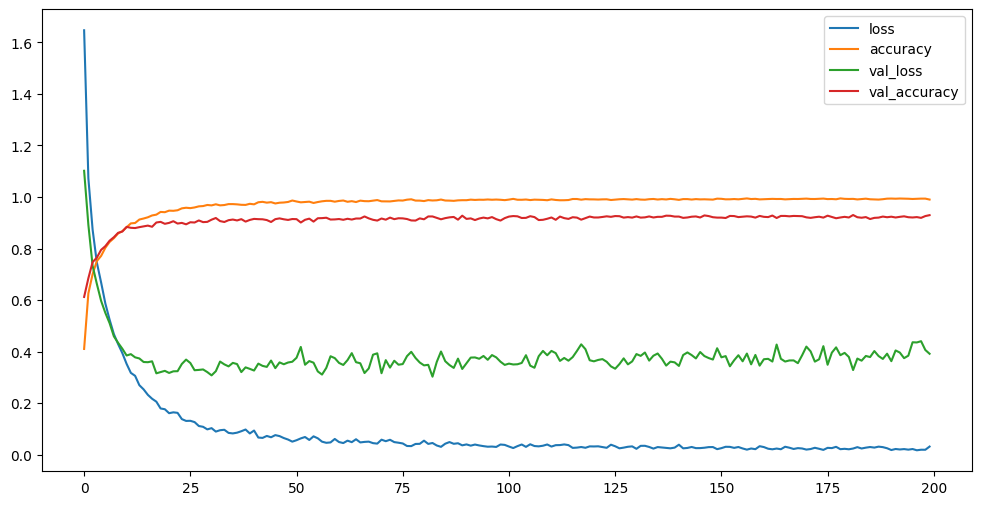

16/16 [==============================] - 0s 3ms/step - loss: 0.3915 - accuracy: 0.9294


In [27]:
# And evaluate our results
plotValidate(model_history)
results = model.evaluate(X_test, y_test, batch_size=128)

From the loss/accuracy graph above we can extract several __conclusions__:
 - At ~25 epochs our neural network already reaches fairly decent values
 - Although the training loss still decreses slightly, the values of the train/val accuracy and validation loss remain almost constant already at epoch ~50
 - The difference in between validation and training loss is small, around ~0.4, so we must suspect of overfitting.
 - The final absolute values for all 4 parameters are satisfactory:
     - Train loss: close to 0
     - Train accuracy: close to 1
     - Test loss: ~0.4
     - Test accuracy: ~0.9

63/63 [==============================] - 0s 3ms/step


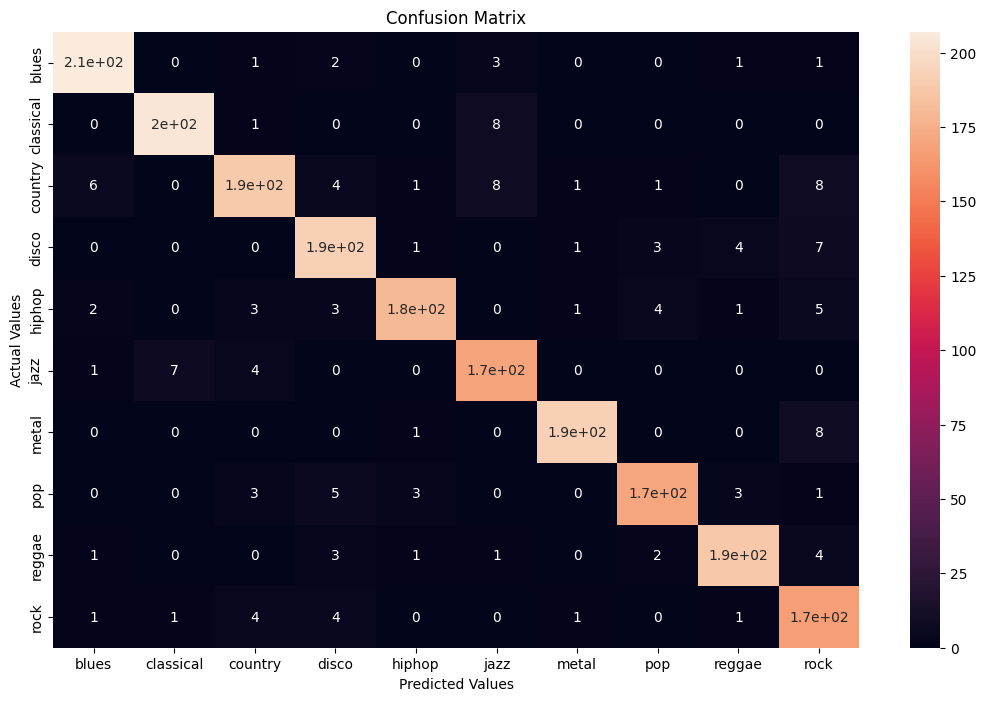

In [28]:
# Multiclass confusion matrix
from sklearn.metrics import confusion_matrix

preds = pd.DataFrame(model.predict(X_test))

# As the CNN final softmax does not output the most likely class, but a probability for each of them,
# we must take the most likely one manually through argmax
lst = []
for i in range(len(preds)):
    lst.append(preds.loc[i].argmax())

cm = confusion_matrix(y_test, lst)

cm_df = pd.DataFrame(cm,
                     index = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"], 
                     columns = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])

plt.figure(figsize=(13,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

From the confusion matrix we can confirm that we nail most of the predictions. It is also interesting to see where are we actually missing. Classical seems to be the most distinct genre of them all for our model: only 3 classical segments are missclassified. 

---

# Random Forest
Random forests are a very good choice whenever there is not enough data to properly train a neural network, which could arguably be our case. Moreover, they are quick and easy to implement, so let's train a simple one to compare the results to our CNN.

Random forests are decision trees where we "bag" attributes instead of rows: we train decision trees on different sets of attributes to then "merge" their decisions by averaging them. We hypertune the number of trees and sampled attributes per tree, usually without pruning. It should output less overfitting than our CNN.

Random forests do not mind scaling as much as CNN, so we could have used the original values before Z-score normalization as well.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

In [30]:
random_forest = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)
random_forest.fit(X_train, y_train)
rf_preds = random_forest.predict(X_test)

ic(accuracy_score(y_test,rf_preds))
ic(accuracy_score(y_train, random_forest.predict(X_train)))

ic| accuracy_score(y_test,rf_preds): 0.7977977977977978
ic| accuracy_score(y_train, random_forest.predict(X_train)): 0.9638388388388388


0.9638388388388388

The resulting accuracy is worse than the one we obtained in our CNN, but still faily high (around 0.8). As the training accuracy is 0.96, we still have to suspect about overfitting, although it is slighltly less as in our CNN.

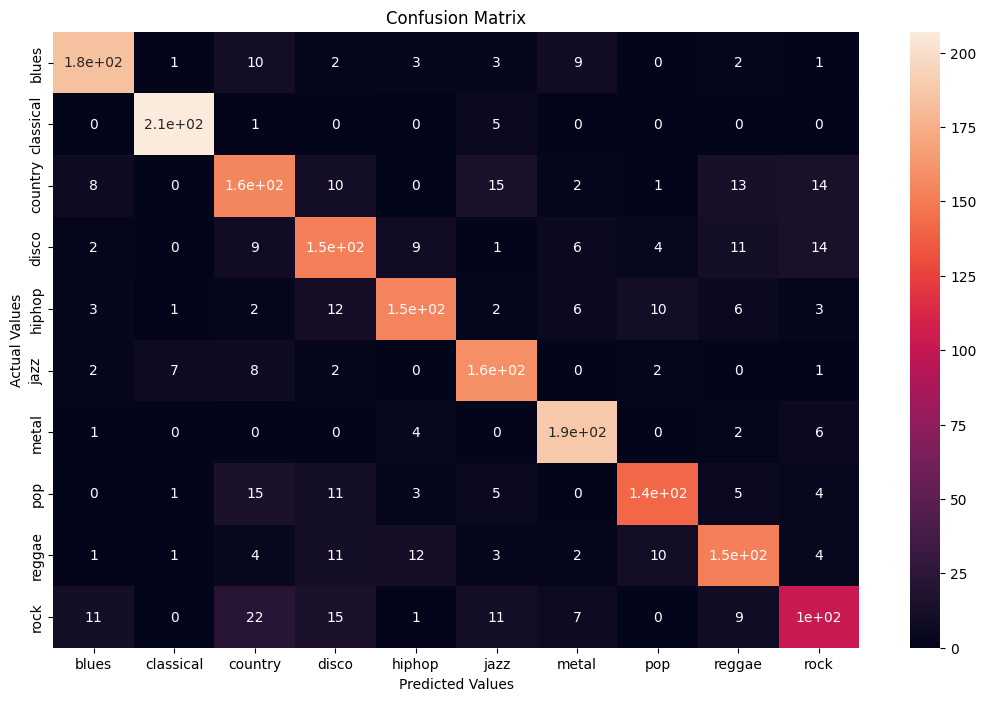

In [31]:
cm2 = confusion_matrix(y_test, rf_preds)

cm_df2 = pd.DataFrame(cm2,
                     index = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"], 
                     columns = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])

plt.figure(figsize=(13,8))
sns.heatmap(cm_df2, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

On the confusion matrix we can see more precisely how worse the results are in comparison to those obtained through our CNN: the accuracy on rock tracks is seriously compromised and classical seems to still be the most distinct class for the random forest classifier.

Interesting enough, many of the missclassifications do make sense: there could be an argument on wether some tracks belong to the actual or the predicted target value.

---

# Making Predictions on real songs
Our final goal is to be able to pass a song through our trained model(s) and see to what genre does our model think that it belongs. Let's start by having a look at what the output of our CNN predictions looks like when we predict on the whole dataset:

In [32]:
# output from using our model to predict on the whole dataset
predictions = pd.DataFrame(model.predict(X))
predictions.tail(5)

313/313 [==============================] - 1s 3ms/step


0             1             2             3             4  \
9985  1.516702e-11  6.867177e-13  1.544183e-10  5.430295e-08  1.357215e-12   
9986  7.406093e-17  6.898315e-17  1.274895e-13  4.944415e-12  9.417668e-16   
9987  1.113716e-12  3.557161e-15  8.078501e-12  4.951975e-12  2.142363e-15   
9988  1.990556e-10  2.018053e-11  7.464481e-09  8.493596e-08  3.376195e-11   
9989  1.590119e-17  3.381935e-16  1.185489e-13  5.060941e-13  1.698639e-15   

                 5             6             7             8    9  
9985  5.853060e-10  5.773106e-11  1.158029e-10  3.158326e-10  1.0  
9986  9.264625e-16  2.050711e-13  1.393524e-13  1.337486e-12  1.0  
9987  1.222678e-12  1.629639e-13  9.274730e-14  1.680164e-09  1.0  
9988  7.450437e-10  1.022410e-09  1.018999e-09  2.114271e-09  1.0  
9989  2.673687e-13  2.010517e-13  4.405469e-12  1.310855e-14  1.0

## Chopping Audio
As our model is trained on 3 second audios, we should chop any song that we want to classify in segments of the same length. While LibROSA is an amazing package for audio analysis, it does not have enough tools for audio manipulation. For such task we will use PyDub. Aditionally, we need our files to ve in .wav format.

In [33]:
from pydub import AudioSegment
from pydub.utils import make_chunks

C:\Users\admin\anaconda3\envs\musicator\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [34]:
def chop_audio(audio_source, chunk_size, song_name):
    # Takes a path to an audio (in .wav format!!!!) as input
    # And chops it into segments of chunck_size seconds 
    # The chunks are locally saved with name song_name
    audio = AudioSegment.from_file(audio_source, "wav")
    audio_chunks = make_chunks(audio, chunk_size*1000)

    for i, chunk in enumerate(audio_chunks):
        chunk_name = song_name+"{0}.wav".format(i)
        chunk.export(chunk_name, format="wav")
    pass

## Audio feature extraction
Let's take it further now: if we want to use our model to find the genre of any other song outside our (limited) dataset, we must first extract from such audio all the features that our model needs as input. The bigger problem here is that we do not know how the authora of the GTZAN dataset obtained their data. 

We will take the first of our audios as a sample, cut the first 3 seconds and try to manually extract similar values for each of the features on the original dataset.

It seems to work fairly well, let's make it into a function and compare the results.

In [36]:
def extract_features(audio_source):
    """Takes the path to an audio as input and outputs its features as a row in the form and order
    of the GTZAN dataset."""
    
    # loading audio and sampling rate
    x, sr = librosa.load(audio_source)
    
    # the function returns two values, we only need the first
    tempo, _ = librosa.beat.beat_track(y=x, sr=sr)

    # generating the 40 mfcc values
    mfcc = pd.DataFrame(librosa.feature.mfcc(y=x, sr=sr))
    mfcc_mean = mfcc.apply(np.mean, axis = 1)
    mfcc_var = mfcc.apply(np.var, axis = 1)

    # creating empty dataframe
    column_names = ["length","chroma_stft_mean","chroma_stft_var","rms_mean","rms_var","spectral_centroid_mean",
                        "spectral_centroid_var","spectral_bandwidth_mean","spectral_bandwidth_var",
                        "rolloff_mean","rolloff_var","zero_crossing_rate_mean","zero_crossing_rate_var",
                        "harmony_mean","harmony_var","perceptr_mean","perceptr_var","tempo","mfcc1_mean",
                        "mfcc1_var","mfcc2_mean","mfcc2_var","mfcc3_mean","mfcc3_var","mfcc4_mean","mfcc4_var",
                        "mfcc5_mean","mfcc5_var","mfcc6_mean","mfcc6_var","mfcc7_mean","mfcc7_var","mfcc8_mean",
                        "mfcc8_var","mfcc9_mean","mfcc9_var","mfcc10_mean","mfcc10_var","mfcc11_mean","mfcc11_var",
                        "mfcc12_mean","mfcc12_var","mfcc13_mean","mfcc13_var","mfcc14_mean","mfcc14_var",
                        "mfcc15_mean","mfcc15_var","mfcc16_mean","mfcc16_var","mfcc17_mean","mfcc17_var",
                        "mfcc18_mean","mfcc18_var","mfcc19_mean","mfcc19_var","mfcc20_mean","mfcc20_var"]
    audio_features = pd.DataFrame(columns = column_names)

    # adding a row to the DataFrame with all the corresponding features
    audio_features.loc[len(audio_features.index)] = [
        66149, #NOT KNOWN YET
        np.mean(librosa.feature.chroma_stft(y=x, sr=sr)),
        np.var(librosa.feature.chroma_stft(y=x, sr=sr)),
        np.mean(librosa.feature.rms(y=x)),
        np.var(librosa.feature.rms(y=x)),
        np.mean(librosa.feature.spectral_centroid(y=x, sr=sr)),
        np.var(librosa.feature.spectral_centroid(y=x, sr=sr)),
        np.mean(librosa.feature.spectral_bandwidth(y=x, sr=sr)),
        np.var(librosa.feature.spectral_bandwidth(y=x, sr=sr)),
        np.mean(librosa.feature.spectral_rolloff(y=x, sr=sr)),
        np.var(librosa.feature.spectral_rolloff(y=x, sr=sr)),
        np.mean(librosa.feature.zero_crossing_rate(y=x)),
        np.var(librosa.feature.zero_crossing_rate(y=x)),
        np.mean(librosa.effects.harmonic(y=x)),
        np.var(librosa.effects.harmonic(y=x)),
        np.mean(librosa.effects.percussive(y=x)), 
        np.var(librosa.effects.percussive(y=x)), 
        tempo,
        mfcc_mean[0], mfcc_var[0], mfcc_mean[1], mfcc_var[1], mfcc_mean[2], mfcc_var[2], mfcc_mean[3],
        mfcc_var[3], mfcc_mean[4], mfcc_var[4], mfcc_mean[5], mfcc_var[5], mfcc_mean[6], mfcc_var[6], 
        mfcc_mean[7], mfcc_var[7], mfcc_mean[8], mfcc_var[8], mfcc_mean[9], mfcc_var[9], mfcc_mean[10],
        mfcc_var[10], mfcc_mean[11], mfcc_var[11], mfcc_mean[12], mfcc_var[12], mfcc_mean[13], mfcc_var[13],
        mfcc_mean[14], mfcc_var[14], mfcc_mean[15], mfcc_var[15], mfcc_mean[16], mfcc_var[16], mfcc_mean[17],
        mfcc_var[17], mfcc_mean[18], mfcc_var[18], mfcc_mean[19], mfcc_var[19],
    ]

    return audio_features

__Success!__ If we compare the values that we obtained with our function for the first 3 second audio file and the ones that were present in the dataset, we see they are all very similar.

In [37]:
# Our manually extracted values for the first 3s chop of the first audio
extract_features('firstaudio0.wav')

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  66149.0          0.335555         0.090997  0.130189  0.003559   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.358004           169450.82952              1972.334258   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0           117272.640189   3714.063439  ...    -2.881668   39.547073   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.230046   36.606857     0.696385   37.766132    -5.035945   33.668545   

   mfcc20_mean  mfcc20_var  
0    -0.239585   43.818882  

[1 rows x 58 columns]

In [38]:
# Original values for the first 3s chop of the first audio
pd.DataFrame(df.drop(["label"], axis = 1).loc[0]).T

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  66149.0          0.335406         0.091048  0.130405  0.003521   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0           117335.771563   3714.560359  ...    -2.853603   39.687145   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0     -3.24128   36.488243     0.722209   38.099152    -5.050335   33.618073   

   mfcc20_mean  mfcc20_var  
0    -0.243027   43.771767  

[1 rows x 58 columns]

In [39]:
# Comparison among the values. We found quite similar ones.
extract_features('firstaudio0.wav') / df.drop(["label"], axis = 1).loc[0]

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0     1.0          1.000444         0.999433  0.998345  1.010737   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1.000165               1.011395                 0.999792   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0                0.999462      0.999866  ...     1.009835    0.996471   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0     0.996534    1.003251     0.964244    0.991259     0.997151    1.001501   

   mfcc20_mean  mfcc20_var  
0     0.985838    1.001076  

[1 rows x 58 columns]

## Putting all together
We prepare here the last couple functions we need to simply input a song and get out our model's prediction.

In [40]:
def label_decoder(i):
    genre_dict = {
        0: 'blues',
        1: 'classical',
        2: 'country',
        3: 'disco',
        4: 'hiphop',
        5: 'jazz',
        6: 'metal',
        7: 'pop',
        8: 'reggae',
        9: 'rock'
    }
    return genre_dict.get(i, 'genre not in dictionary')

A remark on normalization: remember that we used Z-score normalization on the dataset before training the model. Of course, we must normalize our new feature vectors as well before passing it to the model. The problem is that we cannot perform Z-score normalization on a single feature vector ($x -  \mu(x) = 0$).

For now, every time I want to test the model on a new feature vector I just plug it at the very end of my original dataset and perform Z-score on the whole thing. Then, I take for the input only the last row. Another option would be taking the mean and variance of the original dataset and use it to calculate Z-score on the new vectors alone. As we are performing predictions on just one song, the results are almost identical.

In [41]:
def classify_genre(audio_source, model, training_data):
    # Takes as input the audio we want to classify, the CNN model used and the training data
    # And outputs the most likely genre as per our model
    # We need training data for the normalization
    audio_features = extract_features(audio_source)
    standarized_features = fit.fit_transform(np.array(training_data.iloc[:, :-1].append(audio_features), dtype = float))
    predicted_probabilities = model.predict(standarized_features)[-1] # last row is our audio
    return label_decoder(predicted_probabilities.argmax())

In [42]:
def get_genre_probabilities(audio_source, model, training_data):
    # Takes as input the audio we want to classify, the CNN model used, and the training data
    # And outputs the probabilities to belong to each genre as per our model
    # We need training data for normalization
    audio_features = extract_features(audio_source)
    standarized_features = fit.fit_transform(
        np.array(pd.concat([training_data.iloc[:, :-1], audio_features], ignore_index=True), dtype=float)
    )
    df = pd.DataFrame(
        columns=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    )
    df.loc[len(df.index)] = model.predict(standarized_features)[-1]
    return df * 100

In [58]:
def classify_with_rf(audio_source, model, training_data):
    # Takes as input the audio we want to classify, the random forest model used, and the training data
    # And outputs the most likely genre as per our model
    # We need training data for normalization
    audio_features = extract_features(audio_source)
    stand = fit.fit_transform(
        np.array(pd.concat([training_data.iloc[:, :-1], audio_features], ignore_index=True), dtype=float)
    )
    return label_decoder(random_forest.predict(stand[-1].reshape(1, -1))[0])

## Results and experimenting
Now that everything is ready, let's see what our model predicts for several songs. I took and turned into .wav some of my favourite songs of some very different genres. Please bear in mind that this songs are from outside the dataset, you can use your own examples.

In [59]:
# Ludwig van Beethoven - Für Elise: world-wide known classic hit.
ic(classify_with_rf("fur elise.wav",random_forest,df))
get_genre_probabilities("fur elise.wav", model, df)

ic| classify_with_rf("fur elise.wav",random_forest,df): 'classical'


313/313 [==============================] - 1s 3ms/step


blues  classical   country         disco    hiphop      jazz  \
0  4.985861e-08  99.509674  0.000026  4.550178e-07  0.000012  0.490289   

          metal       pop        reggae          rock  
0  5.233134e-09  0.000005  6.289341e-08  6.301700e-07

In [95]:
# Collie Budz - Love and Reggae: modern reggae.
ic(classify_with_rf("Love&Reggae.wav",random_forest,df))
get_genre_probabilities("Love&Reggae.wav", model, df)

ic| ClassifyWithRF("Love&Reggae.wav",random_forest,df): 'hiphop'


blues     classical       country         disco    hiphop  \
0  1.485830e-08  1.186217e-12  6.316251e-10  1.115575e-08  0.000003   

           jazz         metal           pop  reggae          rock  
0  2.025795e-11  2.580903e-09  2.438603e-07   100.0  6.208106e-08

In [96]:
# Niki Istrefi - Red Armor: hard techno (not represented at all in the dataset!).
ic(classify_with_rf("Red Armor.wav",random_forest,df))
get_genre_probabilities("Red Armor.wav", model, df)

ic| ClassifyWithRF("Red Armor.wav",random_forest,df): 'rock'


blues  classical  country     disco  hiphop      jazz     metal  \
0  0.244448   2.509919  2.16497  0.024565  5.8499  0.862604  85.41909   

        pop    reggae      rock  
0  1.062114  1.632378  0.230016

In [97]:
# BlackPink - DDU-DU DDU-DU: korean pop, similar but different to many genres of our datasaet.
ic(classify_with_rf("blackpink.wav",random_forest,df))
get_genre_probabilities("blackpink.wav", model, df)

ic| ClassifyWithRF("blackpink.wav",random_forest,df): 'pop'


blues     classical       country         disco    hiphop  \
0  1.128268e-09  3.513597e-08  4.410870e-09  1.426418e-08  0.000217   

           jazz         metal        pop    reggae          rock  
0  2.167634e-09  9.285078e-10  99.994675  0.005119  3.509779e-08

In [98]:
# Nas - N.Y. State of Mind: east cost hip hop.
ic(classify_with_rf("Nas.wav",random_forest,df))
get_genre_probabilities("Nas.wav", model, df)

ic| ClassifyWithRF("Nas.wav",random_forest,df): 'hiphop'


blues     classical       country     disco     hiphop          jazz  \
0  0.000004  1.231567e-09  2.240274e-08  0.000073  99.911613  6.458687e-09   

      metal       pop    reggae      rock  
0  0.000101  0.004706  0.083505  0.000001

In [99]:
# Daddy Yankee - Gasolina: classic reggaeton tune.
ic(classify_with_rf("Gasolina.wav",random_forest,df))
get_genre_probabilities("Gasolina.wav", model, df)

ic| ClassifyWithRF("Gasolina.wav",random_forest,df): 'reggae'


blues  classical  country      disco    hiphop      jazz     metal  \
0  0.189297   1.351113  1.58382  40.692745  8.141204  0.576678  0.150936   

         pop    reggae     rock  
0  37.612354  8.778386  0.92348

In [100]:
# Rammstein - Du Hast: as per Wikipedia: Neue Deutsche Härte, industrial metal, hard rock, gothic metal.
ic(classify_with_rf("du hast.wav",random_forest,df))
get_genre_probabilities("du hast.wav", model, df)

ic| ClassifyWithRF("du hast.wav",random_forest,df): 'hiphop'


blues  classical  country     disco     hiphop      jazz     metal  \
0  0.044296   0.000801   0.0022  0.211823  97.536102  0.001419  0.292189   

        pop    reggae      rock  
0  0.300342  1.539511  0.071315

In [102]:
# Wu Tang Clan - Method Man: a hip hop classic.
ic(classify_with_rf("WuTang.wav",random_forest,df))
get_genre_probabilities("WuTang.wav", model, df)

ic| ClassifyWithRF("WuTang.wav",random_forest,df): 'reggae'


blues     classical   country    disco    hiphop      jazz     metal  \
0  0.000196  1.102095e-08  0.000009  0.00004  0.006982  0.000005  0.000189   

        pop     reggae      rock  
0  0.000003  99.992371  0.000201

---

# Conclusions, Limitations and Further Research
At first glance, we can confirm that both models are somewhat accurate __on songs that are similar to those on the dataset__. We can also see how CNN hits the target most accurate than the random forest model. Moreover, most of the mistakes make sense and point to genres that are related or heavily influenced to the real one: for instance, the reggaeton (born in Panamá and popularized to Puerto Rico) song is classified as Reggae (developed in Jamaica, Panamá and the caribean zone). 

As it has been stated many times through the work, the biggest __limitation__ has to do with the highly flawed quality of our dataset. Applying the same algorithms on a bigger dataset, with more variety and more genres would certainly yield a nice and fit model able to properly classify very challenging tracks. Furthermore, the overfitting would be way lower.

Improvements and __further research__ in the sense of the neural network composition can get beyond imagination. during the last years we have been witnesses of big tech companies racing in the construction of parallel-computing machines that allow them to perform training on immensely deep neural networks in order to win this or that image-classification challenge. This is of course one direction in which the work could be enhanced. Similarly, there is also room for improvement within the choice of the loss function. While cross-entropy works well enough, it is relatively simple and it could be changed to fit better into our problem setting. I also believe that, out of the 57 attributes we used to train our models, some must be unimportant. It would be interesting to drop them and retrain the models on the remaining ones.

Moreover, the extract_features module that was built in here leaves the door open to grow the GTZAN dataset. For instance, one could gather a collection of music with Creative Commons license, manually label the songs, put each one through extract_features and append the resulting values to the dataset.

